In [2]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import integrate
import AnaUtils as au
import os,glob

In [6]:
def DRun(fname,nbase=50,winS=5,winF=5,cut=4,pmt=0,binw=0.5,ret=False):
    waves = au.ReadDDC10_BinWave(fname)
    waves[0],base = au.Subtract_Baseline(waves[0],nBase=nbase)
    print(base)
    #require baseline has no pulse. i.e. integral over baseline less than cut*rms
    bmask = np.absolute(integrate.simps(waves[0][:,pmt,:nbase]))<cut*integrate.simps(np.ones(nbase))*base[1][:,pmt]
    sumWave = waves[0][:,pmt,:].sum(axis=0)/float(waves[1]['numEvents'])
    PromptPeak = np.argmax(sumWave)
    plt.clf()
    plt.plot(sumWave,label="SumWaves")
    plt.legend(loc="upper left")
    plt.show()
    Qhist = au.winQHist(waves,ch=pmt,init=PromptPeak-winS,end=PromptPeak+winF,binW=binw,hrange=[-3,5])
    if ret:
        Qhist['waves'] = waves[0][:,pmt]
        Qhist['evMask'] = bmask
        Qhist['baserms'] = base[0][:,pmt]
        return Qhist,waves[1]
    else:
        return Qhist['qHist']
    
def plotQ(qhist,sdir,xbase = 1.0):
    plt.clf()
    
    ax = plt.errorbar(qhist[1],qhist[0],marker='+',yerr=np.sqrt(qhist[2]))
    plt.gca().xaxis.set_major_locator(mpl.ticker.MultipleLocator(xbase))
    #plt.yscale("log")
    plt.xlabel('Q [pC]')
    plt.ylabel('dR/dQ [Hz/pC]')
    plt.savefig(sdir+"_DR.png")
    plt.show()

def fullRun(fname,sdir):
    bW = 0.05
    Qhist = DRun(fname,80,3,5,5,0,bW,False)
    plotQ(Qhist,sdir+'/{}'.format(pmt))
    Qbin0 = np.argmax(Qhist[1]>0)
    Qbin1 = np.argmax(Qhist[1]>1.6)
        
    Qvalley = Qbin0 + np.argmin(Qhist[0][Qbin0:Qbin1])
    eDR = np.sum(Qhist[0][Qvalley:])
    eDRErr = np.sqrt(np.sum(Qhist[2][Qvalley:]))
    DR = eDR*bW
    DRErr = DR*eDRErr/eDR
    print([fname,(DR,DRErr)])

In [7]:
pmt = 'KA0196_DR_2208261848_0'
wDir = 'testdata'
fWaves = [os.path.splitext(iF)[0] for iF in glob.glob('{}/{}.bin'.format(wDir,pmt))]
fWaves.sort()
fWaves,

(['testdata/KA0196_DR_2208261848_0'],)

{'numEvents': 25000, 'numSamples': 150, 'chMap': array([1, 0]), 'numChan': 1, 'file': 'testdata/KA0196_DR_2208261848_0'}
(array([[0.00242004],
       [0.0027771 ],
       [0.002742  ],
       ...,
       [0.00277252],
       [0.00275574],
       [0.00277252]]), array([[0.00026378],
       [0.00022467],
       [0.0002105 ],
       ...,
       [0.00018532],
       [0.00019085],
       [0.00021853]]))


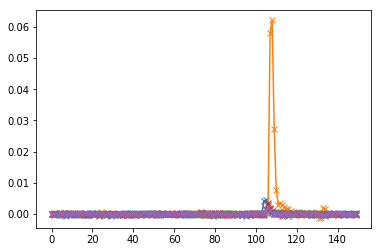

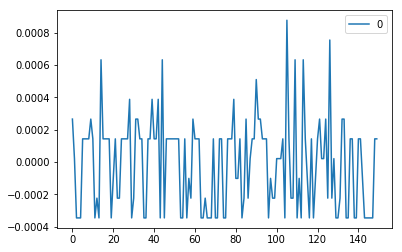

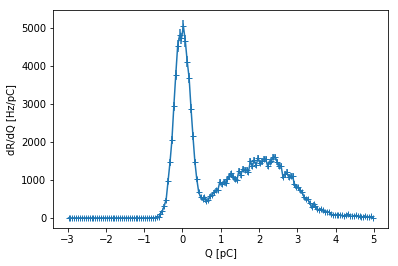

['testdata/KA0196_DR_2208261848_0', 0.6250000000000002, 62920.66073530742, (3146.0330367653714, 27.726155844896127)]


[None]

In [40]:
[fullRun(fWave,'.',False) for fWave in fWaves[:]]